# RNA-seq comparison vs H3K4me3 and H3K36me3

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [4]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [5]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [6]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

/tmp/ipykernel_414763/386494431.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


In [7]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [8]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    # df_span = df_span[['_200_' in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [9]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 33


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 33


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 33


  0%|          | 0/359 [00:00<?, ?it/s]

SPAN 33


,file,modification,cell,replicate,peaks,tool,dataset
88,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me3,NHEK,rep1,33494,SICER,ENCODE
86,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K36me3,NHEK,rep2,46199,SICER,ENCODE
62,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,HepG2,rep2,24303,MACS2 broad,ENCODE
16,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,HMEC,rep2,109427,MACS2,ENCODE
48,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,HepG2,rep1,54590,MACS2 broad,ENCODE


In [10]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 20


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 20


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 20


  0%|          | 0/196 [00:00<?, ?it/s]

SPAN 20


,file,modification,cell,replicate,peaks,tool,dataset
62,/home/jetbrains/data/2023_Immune/span/CD34_H3K...,H3K36me3,CD34,,22267,SPAN,Roadmap
76,/home/jetbrains/data/2023_Immune/span/CD34_H3K...,H3K36me3,CD34,rep1,36708,SPAN,Roadmap
78,/home/jetbrains/data/2023_Immune/span/CD4ABT_H...,H3K4me3,CD4ABT,rep1,19878,SPAN,Roadmap
5,/home/jetbrains/data/2023_Immune/macs2/Monocyt...,H3K4me3,Monocyte,,26555,MACS2,Roadmap
39,/home/jetbrains/data/2023_Immune/macs2/CD34_H3...,H3K36me3,CD34,,129062,MACS2 broad,Roadmap


In [11]:
df_peaks_full = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

In [12]:
# Remove outliers, see 2023 - figures.ipynb
# Remove outliers
OUTLIERS = [
    ('H3K4me3', 'NK', ''),
    ('H3K27ac', 'CD34', 'rep2'),
    ('H3K4me1', 'NK', ''),
    ('H3K27me3', 'BCell', ''),
    ('H3K27me3', 'TCell', ''),
]
df_peaks = df_peaks_full.loc[[(m, c, r) not in OUTLIERS
                              for _, (m, c, r) in df_peaks_full[['modification', 'cell', 'replicate']].iterrows()]].copy()

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the

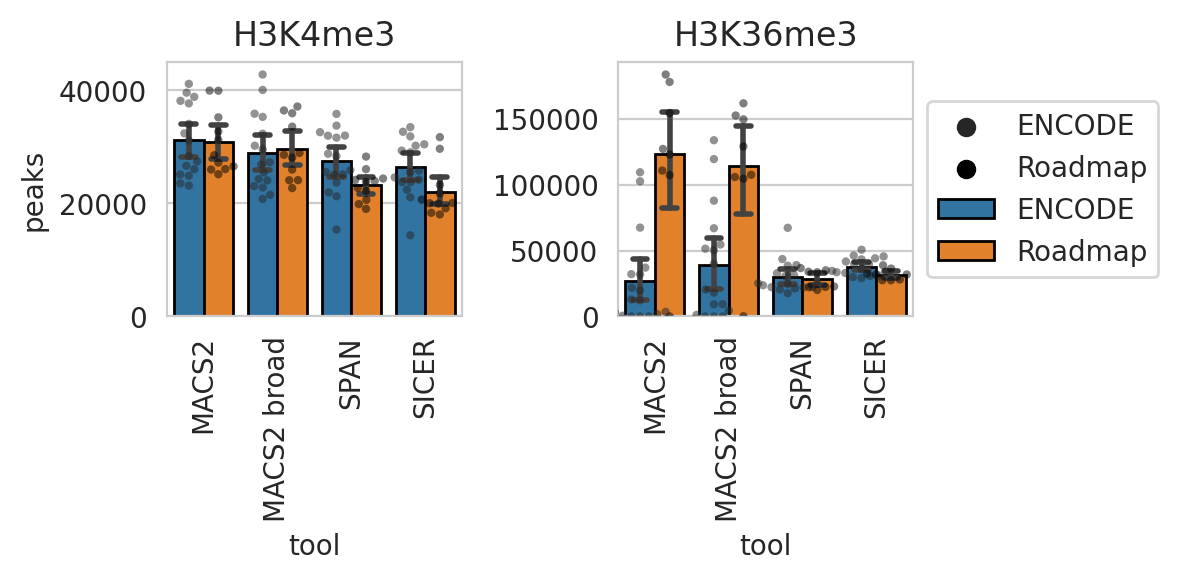

In [13]:
plt.figure(figsize=(6, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, color="black", alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# H3K4me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps the promoter of an expressed gene (RPKM > 0.5).
The top 15 000 peak calls from the different methods are ranked by their significance or by their fold enrichment for the thresholding method. We plotted the correct peak fraction (fraction of the top 1000xn peaks that overlap with active promoters) detected as a function of the correct promoter fraction (fraction of the active promoters that overlap with the top 1000xn peaks).

In [18]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

,chromosome,db,type,start,end,point1,strand,point2,aux
3166563,chr21,HAVANA,CDS,41449137,41449295,.,+,2,"gene_id ""ENSG00000157601.15""; transcript_id ""E..."
2580884,chr16,HAVANA,start_codon,68245427,68245429,.,+,0,"gene_id ""ENSG00000103066.13""; transcript_id ""E..."
652375,chr3,HAVANA,CDS,52451744,52451858,.,-,2,"gene_id ""ENSG00000114854.8""; transcript_id ""EN..."
1903780,chr11,HAVANA,CDS,68938182,68938354,.,+,2,"gene_id ""ENSG00000132740.10""; transcript_id ""E..."
622636,chr3,HAVANA,exon,42512058,42512311,.,-,.,"gene_id ""ENSG00000232354.8""; transcript_id ""EN..."
822184,chr4,HAVANA,exon,41612902,41613098,.,+,.,"gene_id ""ENSG00000064042.18""; transcript_id ""E..."
1947754,chr11,HAVANA,exon,108272532,108272607,.,+,.,"gene_id ""ENSG00000149311.20""; transcript_id ""E..."
2985446,chr19,HAVANA,CDS,38597486,38597594,.,-,2,"gene_id ""ENSG00000104814.13""; transcript_id ""E..."
106223,chr1,HAVANA,CDS,53093461,53093560,.,-,2,"gene_id ""ENSG00000162383.13""; transcript_id ""E..."
3355520,chrX,HAVANA,CDS,153556331,153556418,.,+,0,"gene_id ""ENSG00000067842.18""; transcript_id ""E..."


In [19]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [20]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


,chromosome,db,type,start,end,point1,strand,point2,gene_id,gene_type,gene_name,level
1693659,chr10,HAVANA,gene,51244894,51245806,.,-,.,ENSG00000231132,lncRNA,ENSG00000231132,2
3369214,chrY,HAVANA,gene,11306918,11308181,.,+,.,ENSG00000258567,unprocessed_pseudogene,DUX4L16,1
2999203,chr19,HAVANA,gene,41837074,41844697,.,-,.,ENSG00000273111,protein_coding,LYPD4,2
631758,chr3,HAVANA,gene,47802909,47850195,.,+,.,ENSG00000132153,protein_coding,DHX30,1
251505,chr1,HAVANA,gene,193304745,193365953,.,+,.,ENSG00000232077,lncRNA,LINC01031,2


## Annotate quanitified RNA-seq with TSS positions

In [21]:
def merge_genes(full_df):
    print('Merging overlapping regions', len(full_df))
    ts = []
    for chr in full_df['chromosome'].unique():
        t = full_df[full_df['chromosome'] == chr].sort_values(by=['start', 'end']).copy()
        cols = t.columns.difference(['start', 'end'])
        grps = t['start'].sub(t['end'].shift()).gt(1).cumsum()
        gpby = t.groupby(grps)
        t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
        t['chromosome'] = chr
        t['gene_id'] = 'merged'
        t['strand'] = '.'
        t = t[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        ts.append(t)
    ts = pd.concat(ts).reset_index(drop=True)
    print('Reduced to', len(ts))
    return ts

In [22]:
import re

GSE26320_RNASEQ_PATH = os.path.expanduser('~/data/2023_GSE26320_rnaseq')

GSE26320_EXPRESSION_TSV = {
    ('GM12878', 'rep1') : GSE26320_RNASEQ_PATH + '/GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv',
    ('GM12878', 'rep2'): GSE26320_RNASEQ_PATH + '/GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv',
    ('H1', 'rep1') : GSE26320_RNASEQ_PATH + '/H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('H1', 'rep2') : GSE26320_RNASEQ_PATH + '/H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('HMEC', 'rep1') : GSE26320_RNASEQ_PATH + '/HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv',
    ('HMEC', 'rep2') : GSE26320_RNASEQ_PATH + '/HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv',
    ('HSMM', 'rep1') : GSE26320_RNASEQ_PATH + '/HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv',
    ('HSMM', 'rep2') : GSE26320_RNASEQ_PATH + '/HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv',
    ('HepG2', 'rep1') : GSE26320_RNASEQ_PATH + '/HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv',
    ('HepG2', 'rep2') : GSE26320_RNASEQ_PATH + '/HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv',
    ('Huvec', 'rep1') : GSE26320_RNASEQ_PATH + '/Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv',
    ('Huvec', 'rep2') : GSE26320_RNASEQ_PATH + '/Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv',
    ('K562', 'rep1') : GSE26320_RNASEQ_PATH + '/K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv',
    ('K562', 'rep2') : GSE26320_RNASEQ_PATH + '/K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv',
    ('NHEK', 'rep1') : GSE26320_RNASEQ_PATH + '/NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHEK', 'rep2') : GSE26320_RNASEQ_PATH + '/NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHLF', 'rep1') : GSE26320_RNASEQ_PATH + '/NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv',
    ('NHLF', 'rep2') : GSE26320_RNASEQ_PATH + '/NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv'
}

In [23]:
IMMUNE_EXPRESSION_TSV = {
    ('BCell', ''): IMMUNE_PATH + '/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv',
    ('TCell', ''): IMMUNE_PATH + '/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv',
    ('Monocyte', ''): IMMUNE_PATH + '/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv',
}

## Prepare track with TSS of expressed genes

In [24]:
TSS = 500
THRESHOLD = 0.1

def prepare_expressed(expression_tsv):
    result_tss = {}
    result_gene = {}
    ts = []
    for (cell, rep), path in tqdm(expression_tsv.items()):
        print(cell, rep, path)
        t = pd.read_csv(path, sep='\t')
        # Fix . in gene_id
        t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
        t['LTPM'] = np.log1p(t['TPM'])
        t['name'] = f'{cell} {rep}'
        ts.append(t)

        # Save expressed genes
        full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
        print(f'Total genes with positions {len(full_df)}')
        full_df = full_df[full_df['LTPM'] > THRESHOLD].copy()
        print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')
        
        full_df.sort_values(by=['chromosome', 'start'], inplace=True)

        gene_path = path.replace('.tsv', f'_tpm{THRESHOLD}.bed')
        full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']].to_csv(
            gene_path, sep='\t', index=False, header=None)
        print(f'Saved body expressed genes fom {cell} to {gene_path}')
        result_gene[(cell, rep)] = gene_path
        
        starts = [
            max(1, start - TSS if strand == '+' else end - TSS)
            for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
        ]
        ends = [
            start + TSS if strand == '+' else end + TSS
            for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
        ]
        full_df['start'] = starts
        full_df['end'] = ends
        full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        full_df.sort_values(by=['chromosome', 'start'], inplace=True)
        full_df = merge_genes(full_df)

        tss_path = path.replace('.tsv', f'_tpm{THRESHOLD}_tss{TSS}.bed')
        full_df.to_csv(tss_path, sep='\t', index=False, header=None)
        print(f'Saved TSS expressed genes fom {cell} to {tss_path}')
        result_tss[(cell, rep)] = tss_path
    
    # Plot expression
    # plt.figure(figsize=(10, 4))
    # ax = plt.axes()
    # sns.histplot(data=pd.concat(ts).reset_index(drop=True), 
    #              x='LTPM', hue='name', 
    #              stat='density', bins=500, kde=True, alpha=0.4,
    #              ax=ax,
    #              )
    # ax.axvline(x=THRESHOLD, color='green')
    # ax.title.set_text('Expression')
    # Put a legend to the right of the current axis
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.tight_layout()
    # plt.show()
    return result_gene, result_tss

In [25]:
encode_expression, encode_tss_expression = prepare_expressed(GSE26320_EXPRESSION_TSV)

  0%|          | 0/18 [00:00<?, ?it/s]

GM12878 rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv
Total genes with positions 58387
Genes logTPM > 0.1 15835
Saved body expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_tpm0.1.bed
Merging overlapping regions 15835


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 13836
Saved TSS expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_tpm0.1_tss500.bed
GM12878 rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv
Total genes with positions 56646
Genes logTPM > 0.1 15750
Saved body expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_tpm0.1.bed
Merging overlapping regions 15750


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 13803
Saved TSS expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_tpm0.1_tss500.bed
H1 rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv
Total genes with positions 56646
Genes logTPM > 0.1 19379
Saved body expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.1.bed
Merging overlapping regions 19379


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 17085
Saved TSS expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.1_tss500.bed
H1 rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv
Total genes with positions 56646
Genes logTPM > 0.1 19379
Saved body expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.1.bed
Merging overlapping regions 19379


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 17085
Saved TSS expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.1_tss500.bed
HMEC rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv
Total genes with positions 58387
Genes logTPM > 0.1 20029
Saved body expressed genes fom HMEC to /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep1_RNAseq_hg38_ENCFF292FVY_tpm0.1.bed
Merging overlapping regions 20029


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 17476
Saved TSS expressed genes fom HMEC to /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep1_RNAseq_hg38_ENCFF292FVY_tpm0.1_tss500.bed
HMEC rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv
Total genes with positions 58387
Genes logTPM > 0.1 19373
Saved body expressed genes fom HMEC to /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep2_RNAseq_hg38_ENCFF219EZH_tpm0.1.bed
Merging overlapping regions 19373


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 16935
Saved TSS expressed genes fom HMEC to /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep2_RNAseq_hg38_ENCFF219EZH_tpm0.1_tss500.bed
HSMM rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv
Total genes with positions 52065
Genes logTPM > 0.1 14527
Saved body expressed genes fom HSMM to /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep1_RNAseq_hg38_ENCFF551YKI_tpm0.1.bed
Merging overlapping regions 14527


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 12943
Saved TSS expressed genes fom HSMM to /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep1_RNAseq_hg38_ENCFF551YKI_tpm0.1_tss500.bed
HSMM rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv
Total genes with positions 52065
Genes logTPM > 0.1 14501
Saved body expressed genes fom HSMM to /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep2_RNAseq_hg38_ENCFF497BUG_tpm0.1.bed
Merging overlapping regions 14501


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 12942
Saved TSS expressed genes fom HSMM to /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep2_RNAseq_hg38_ENCFF497BUG_tpm0.1_tss500.bed
HepG2 rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv
Total genes with positions 56646
Genes logTPM > 0.1 17858
Saved body expressed genes fom HepG2 to /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep1_RNAseq_hg38_ENCFF773JNC_tpm0.1.bed
Merging overlapping regions 17858


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 15531
Saved TSS expressed genes fom HepG2 to /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep1_RNAseq_hg38_ENCFF773JNC_tpm0.1_tss500.bed
HepG2 rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv
Total genes with positions 56646
Genes logTPM > 0.1 17175
Saved body expressed genes fom HepG2 to /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep2_RNAseq_hg38_ENCFF570ZOT_tpm0.1.bed
Merging overlapping regions 17175


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 14951
Saved TSS expressed genes fom HepG2 to /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep2_RNAseq_hg38_ENCFF570ZOT_tpm0.1_tss500.bed
Huvec rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv
Total genes with positions 58387
Genes logTPM > 0.1 19939
Saved body expressed genes fom Huvec to /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep1_RNAseq_hg38_ENCFF454MTF_tpm0.1.bed
Merging overlapping regions 19939


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 17448
Saved TSS expressed genes fom Huvec to /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep1_RNAseq_hg38_ENCFF454MTF_tpm0.1_tss500.bed
Huvec rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv
Total genes with positions 58387
Genes logTPM > 0.1 19526
Saved body expressed genes fom Huvec to /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep2_RNAseq_hg38_ENCFF134FYP_tpm0.1.bed
Merging overlapping regions 19526


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 17037
Saved TSS expressed genes fom Huvec to /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep2_RNAseq_hg38_ENCFF134FYP_tpm0.1_tss500.bed
K562 rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv
Total genes with positions 52065
Genes logTPM > 0.1 15270
Saved body expressed genes fom K562 to /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep1_RNAseq_hg38_ENCFF139IXQ_tpm0.1.bed
Merging overlapping regions 15270


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 13424
Saved TSS expressed genes fom K562 to /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep1_RNAseq_hg38_ENCFF139IXQ_tpm0.1_tss500.bed
K562 rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv
Total genes with positions 52065
Genes logTPM > 0.1 15092
Saved body expressed genes fom K562 to /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep2_RNAseq_hg38_ENCFF088RDE_tpm0.1.bed
Merging overlapping regions 15092


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 13267
Saved TSS expressed genes fom K562 to /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep2_RNAseq_hg38_ENCFF088RDE_tpm0.1_tss500.bed
NHEK rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv
Total genes with positions 58387
Genes logTPM > 0.1 18674
Saved body expressed genes fom NHEK to /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA_tpm0.1.bed
Merging overlapping regions 18674


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 16615
Saved TSS expressed genes fom NHEK to /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA_tpm0.1_tss500.bed
NHEK rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv
Total genes with positions 58387
Genes logTPM > 0.1 18674
Saved body expressed genes fom NHEK to /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA_tpm0.1.bed
Merging overlapping regions 18674


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 16615
Saved TSS expressed genes fom NHEK to /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA_tpm0.1_tss500.bed
NHLF rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv
Total genes with positions 58387
Genes logTPM > 0.1 17520
Saved body expressed genes fom NHLF to /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep1_RNAseq_hg38_ENCFF577DEC_tpm0.1.bed
Merging overlapping regions 17520


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 15261
Saved TSS expressed genes fom NHLF to /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep1_RNAseq_hg38_ENCFF577DEC_tpm0.1_tss500.bed
NHLF rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv
Total genes with positions 58387
Genes logTPM > 0.1 17924
Saved body expressed genes fom NHLF to /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep2_RNAseq_hg38_ENCFF412KNK_tpm0.1.bed
Merging overlapping regions 17924


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 15634
Saved TSS expressed genes fom NHLF to /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep2_RNAseq_hg38_ENCFF412KNK_tpm0.1_tss500.bed


In [26]:
immune_expression, immune_tss_expression = prepare_expressed(IMMUNE_EXPRESSION_TSV)

  0%|          | 0/3 [00:00<?, ?it/s]

BCell  /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv
Total genes with positions 58387
Genes logTPM > 0.1 20769
Saved body expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_tpm0.1.bed
Merging overlapping regions 20769


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 18107
Saved TSS expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_tpm0.1_tss500.bed
TCell  /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv
Total genes with positions 58387
Genes logTPM > 0.1 21110
Saved body expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_tpm0.1.bed
Merging overlapping regions 21110


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 18413
Saved TSS expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_tpm0.1_tss500.bed
Monocyte  /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv
Total genes with positions 58387
Genes logTPM > 0.1 18584
Saved body expressed genes fom Monocyte to /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO_tpm0.1.bed
Merging overlapping regions 18584


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

Reduced to 16146
Saved TSS expressed genes fom Monocyte to /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO_tpm0.1_tss500.bed


/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
/tmp/ipykernel_414763/864504931.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = gpby.agg(dict(start='min', end=

# Hg38 Recovered promoter fraction / Correct peak fraction

In [96]:
import pyranges as pr
from pyranges import PyRanges

def promote_fraction(df_peaks, expression_tss):
    PyRanges()
    rows = []
    for _, (c, r, tool, file) in tqdm(list(df_peaks[df_peaks['modification'] == 'H3K4me3']
                                      [['cell', 'replicate', 'tool', 'file']].iterrows())):
        # print(c, r, tool, file)
        if (c, r) not in expression_tss:
            continue
        tss_file = pr.read_bed(sorted_file(expression_tss[c, r]))
        tss = len(tss_file)
        if lines(file) == 0:
            for top in np.linspace(1000, 15000, 15):
                rows.append((c, r, top, tss, file, 0, 0, 0, tool))
            continue
        peaks_file = pr.read_bed(sorted_file(file), as_df=True)
        peaks_file.sort_values(
            by=peaks_file.columns[8] if len(peaks_file.columns) >= 9 else peaks_file.columns[4],
            ascending=False, inplace=True
        )
        for top in np.linspace(1000, 15000, 15):
            t = PyRanges(peaks_file.head(int(top)).sort_values(by=['Chromosome', 'Start']))
            peaks = len(t)
            peaks_overlap = len(t.overlap(tss_file))
            tss_overlap = len(tss_file.overlap(t))
            rows.append((c, r, top, tss, file, peaks, peaks_overlap, tss_overlap, tool))

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
        dtype=object
    )
    df['p'] = (df['pg'] + df['gp']) / 2
    df['precision'] = [d(x, y) for x, y in zip(df['pg'], df['peaks'])]
    df['sensitivity'] = [d(x, y) for x, y in zip(df['gp'], df['genes'])]
    df['f1'] = [
        2 / (d(1, s + 1e-10) + d(1, p + 1e-10))
        for s, p in zip(df['sensitivity'], df['precision'])]
    return df

In [60]:
encode_cpf_df = promote_fraction(df_encode_peaks, encode_tss_expression)
encode_cpf_df.sample(3)

  0%|          | 0/64 [00:00<?, ?it/s]

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
447,HepG2,rep2,13000.0,14951,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,13000,9237,8631,MACS2 broad,8934.0,0.710538,0.577286,0.637018
956,NHEK,rep1,12000.0,16615,/home/jetbrains/data/2023_GSE26320/span/GSM646...,12000,8692,8987,SPAN,8839.5,0.724333,0.540897,0.619317
496,HMEC,rep2,2000.0,16935,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,2000,1522,1694,SICER,1608.0,0.761000,0.100030,0.176817


In [61]:
immune_cpf_df = promote_fraction(df_immune_peaks, immune_tss_expression)
immune_cpf_df.sample(3)

ENCODE


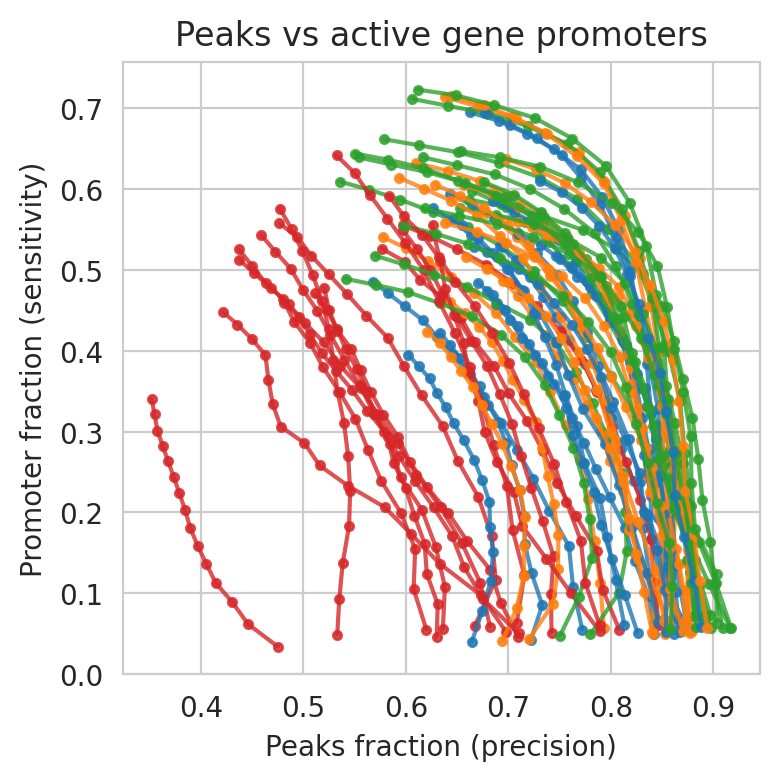

In [69]:
print('ENCODE')
plt.figure(figsize=(4, 4))
for (c, r, t), dft in encode_cpf_df.groupby(['cell', 'replicate', 'tool']):    
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.8)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

ENCODE


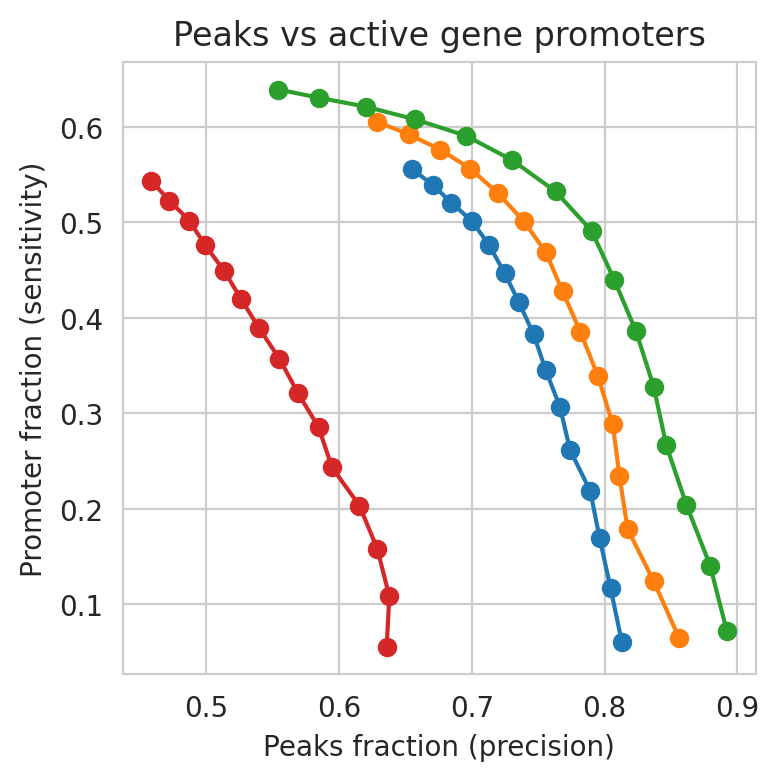

In [70]:
print('ENCODE')
plt.figure(figsize=(4, 4))
cr = encode_cpf_df[(encode_cpf_df['cell'] == 'K562') & (encode_cpf_df['replicate'] == 'rep1')]
for (c, r, t), dft in cr.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', color=TOOLS_PALETTE[t], alpha=1)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

Roadmap


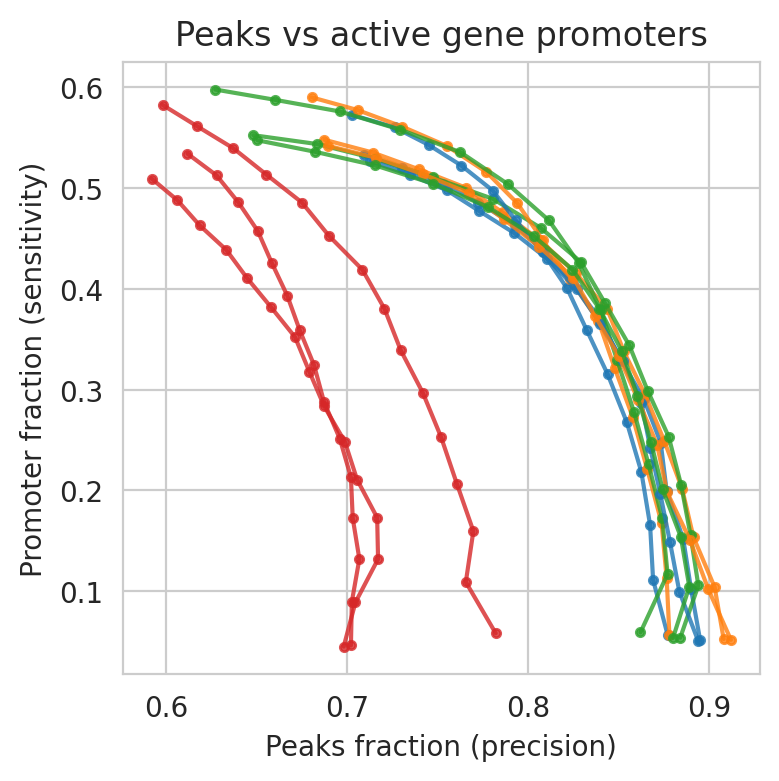

In [71]:
print('Roadmap')
plt.figure(figsize=(4, 4))
for (c, r, t), dft in immune_cpf_df.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.8)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

Immune


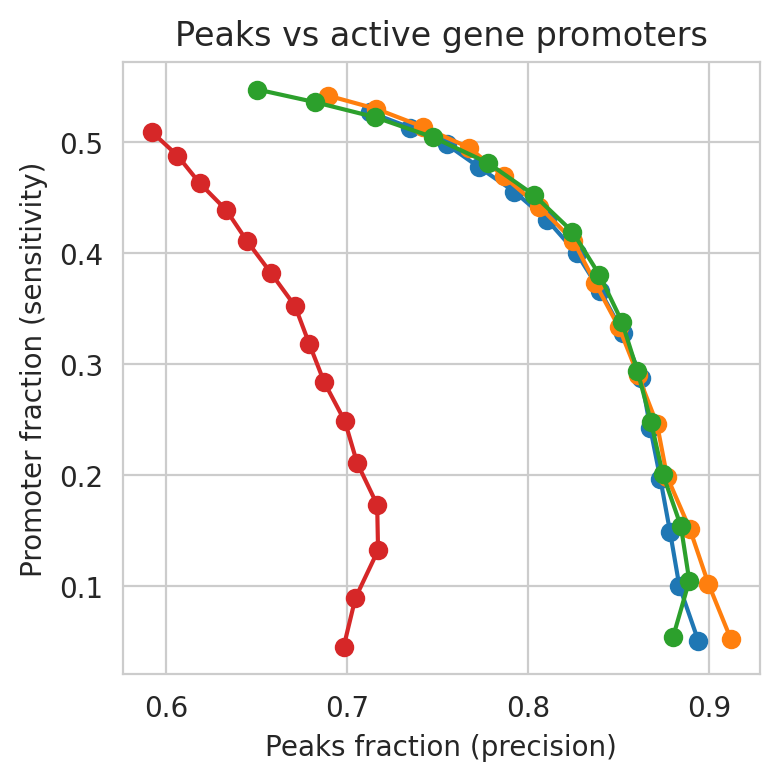

In [72]:
print('Immune')
plt.figure(figsize=(4, 4))
cr = immune_cpf_df[immune_cpf_df['cell'] == 'TCell']
for (c, r, t), dft in cr.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', color=TOOLS_PALETTE[t], alpha=1)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

ENCODE + Roadmap


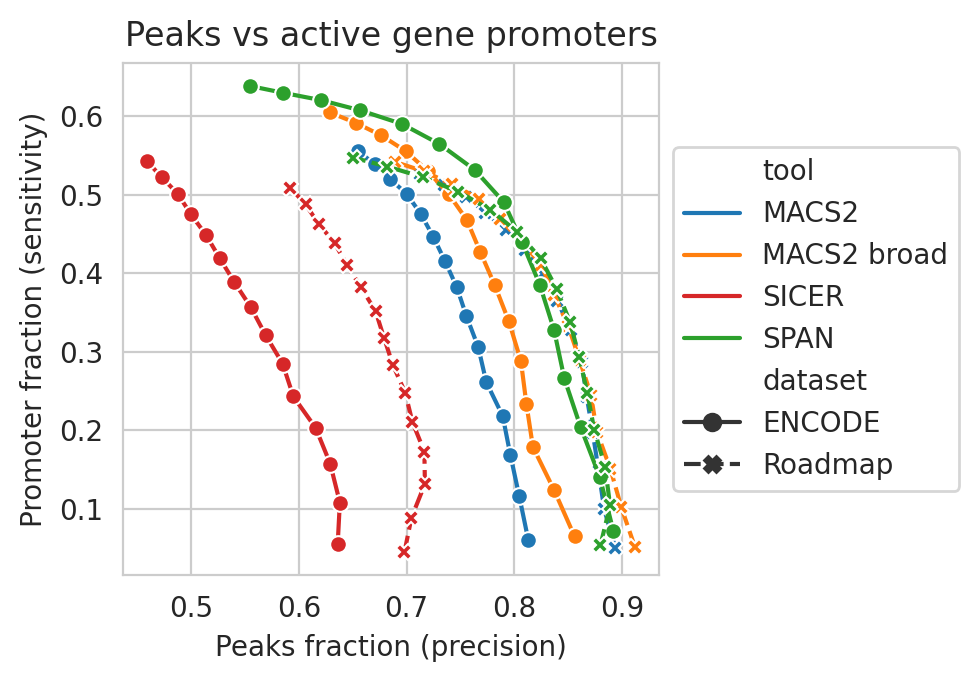

In [73]:
print('ENCODE + Roadmap')
plt.figure(figsize=(5, 3.5))
t1 = encode_cpf_df[(encode_cpf_df['cell'] == 'K562') & (encode_cpf_df['replicate'] == 'rep1')].copy()
t1['dataset'] = 'ENCODE'
t2 = immune_cpf_df[immune_cpf_df['cell'] == 'TCell'].copy()
t2['dataset'] = 'Roadmap'
cr = pd.concat([t1, t2]).reset_index(drop=True)
ax = plt.axes()
sns.lineplot(
    data=cr,
    x='precision', y='sensitivity', style='dataset',
    hue='tool',
    markers=True, sort=False,
    palette=TOOLS_PALETTE,
    ax=ax
)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Peaks vs active gene promoters')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Promoter fraction (sensitivity)')
plt.tight_layout()
plt.show()

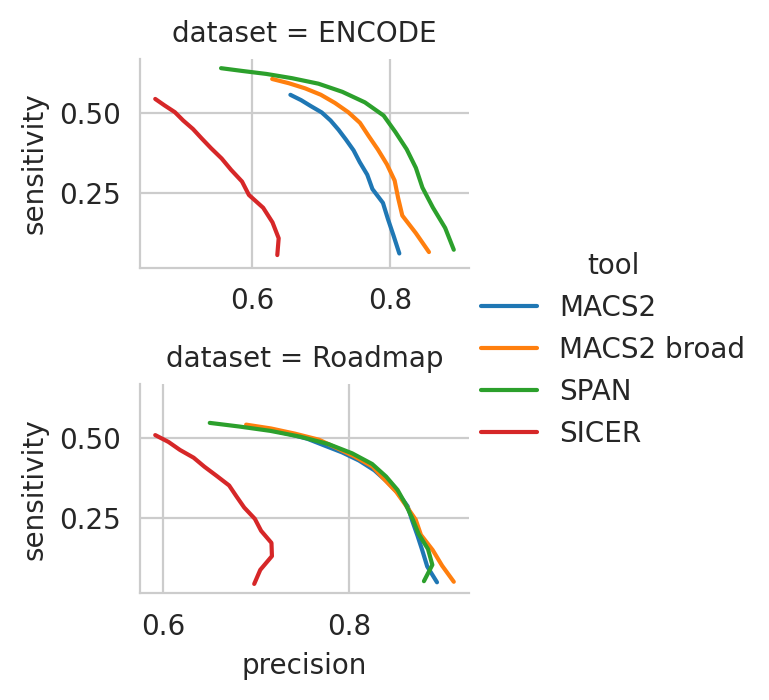

In [74]:
g = sns.FacetGrid(cr, hue="tool", row="dataset", height=1.8, aspect=1.5, palette=TOOLS_PALETTE, 
                  hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], sharex=False)
g.map(sns.lineplot, "precision", "sensitivity", sort=False)
g.add_legend()
plt.show()

## Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

In [75]:
rows = []
for (c, r, t), dft in encode_cpf_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = 0, 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
encode_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
encode_aps_df.sample(3)

,cell,replicate,tool,auc
24,HSMM,rep1,MACS2,0.546048
47,K562,rep1,SPAN,0.491145
6,GM12878,rep2,SICER,0.327011


ENCODE


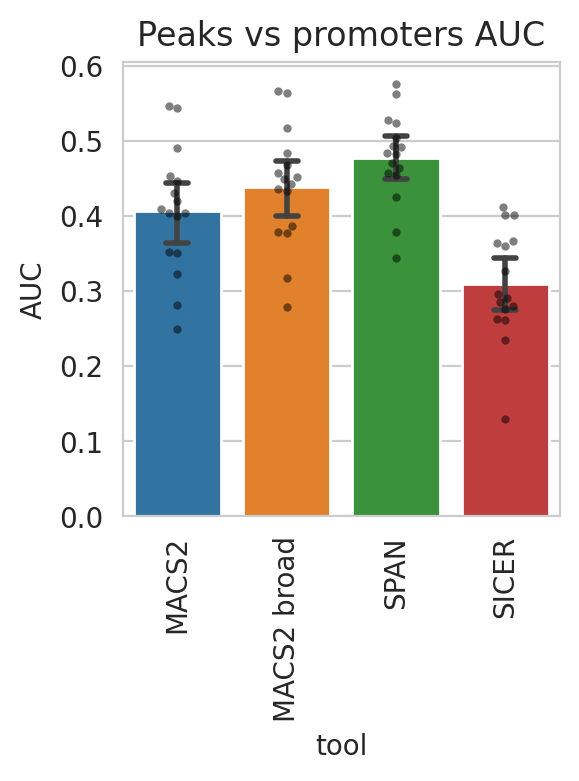

In [76]:
print('ENCODE')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
sns.barplot(data=encode_aps_df, x='tool', y='auc',
            capsize=.2, errwidth=2,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=encode_aps_df, x='tool', y='auc',
              dodge=True, size=3, color="black", alpha=0.5,
              order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)

ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

In [77]:
rows = []
for (c, r, t), dft in immune_cpf_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = 0, 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
immune_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
immune_aps_df.sample(3)

,cell,replicate,tool,auc
0,BCell,,MACS2,0.430319
3,BCell,,SPAN,0.445386
9,TCell,,MACS2 broad,0.437933


Roadmap


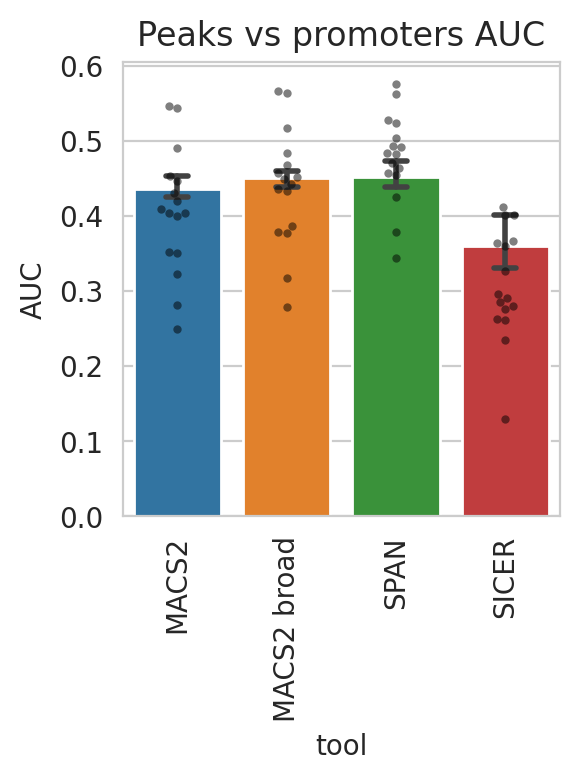

In [78]:
print('Roadmap')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
sns.barplot(data=immune_aps_df, x='tool', y='auc',
            capsize=.2, errwidth=2,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=encode_aps_df, x='tool', y='auc',
              dodge=True, size=3, color="black", alpha=0.5,
              order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

Roadmap + ENCODE


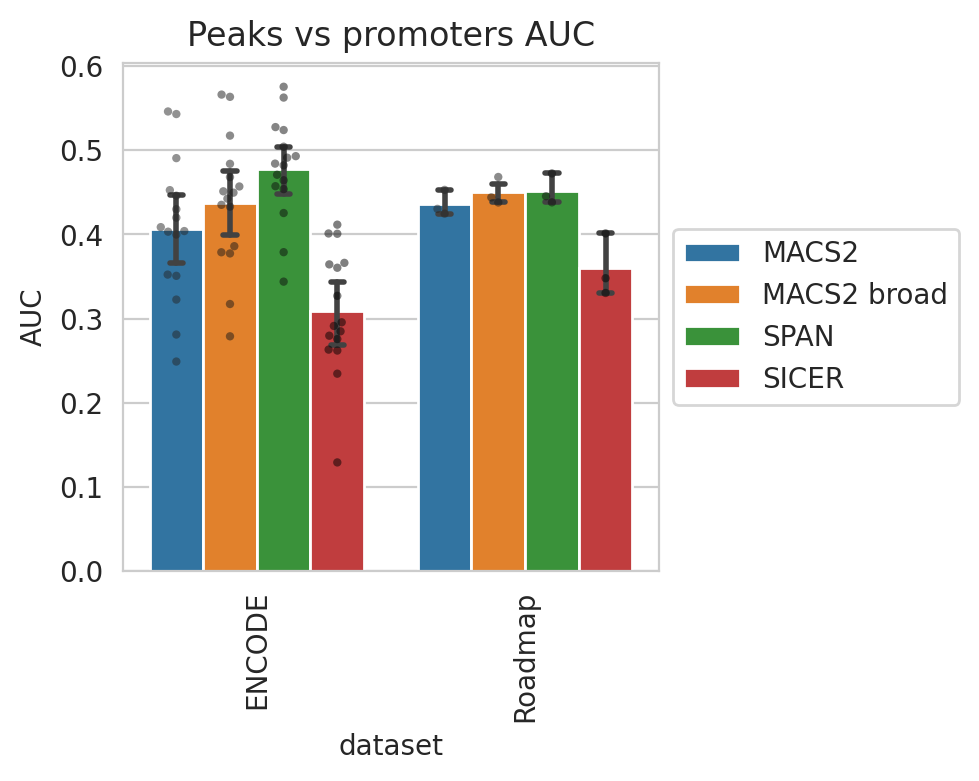

In [79]:
print('Roadmap + ENCODE')
encode_aps_df['dataset'] = 'ENCODE'
immune_aps_df['dataset'] = 'Roadmap'
t = pd.concat([encode_aps_df, immune_aps_df]).reset_index(drop=True)
plt.figure(figsize=(5, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
sns.barplot(data=t, x='dataset', y='auc', hue='tool',
            capsize=.05, errwidth=2,
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='auc', hue='tool',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], 
              legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

# Jaccard H3K36me3 vs expressed genes bodies

In [82]:
import tempfile

def genes_overlap(df_peaks, expression):
    rows = []
    for _, (c, r, tool, file) in tqdm(list(df_peaks[df_peaks['modification'] == 'H3K36me3']
                                      [['cell', 'replicate', 'tool', 'file']].iterrows())):
        # print(c, r, tool, file)
        if (c, r) not in expression:
            continue
        genes_file = pr.read_bed(sorted_file(expression[c, r]))
        genes = len(genes_file)
        genes_len = genes_file.lengths().sum()
        peaks = lines(file)
        if peaks == 0:
            rows.append((c, r, tool, 0, 0, genes, genes_len, 0, 0, 0))
            continue
        peaks_file = pr.read_bed(sorted_file(file))
        peaks_len = bedl(peaks_file).sum()
        peaks_overlap = len(peaks_file.overlap(genes_file)) 
        genes_overlap = len(genes_file.overlap(peaks_file))
        overlap_len = peaks_file.intersect(genes_file).lengths().sum()
        rows.append((c, r, tool, 
                     peaks, peaks_len, genes, genes_len,
                     peaks_overlap, genes_overlap, overlap_len))

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'tool',
                 'peaks', 'peaks_len', 'genes', 'genes_len',
                 'peaks_overlap', 'genes_overlap', 'overlap_len'],
        dtype=object
    )
    df['precision'] = [d(a, b) for a, b in zip(df['peaks_overlap'], df['peaks'])]
    df['sensitivity'] = [d(a, b) for a, b in zip(df['genes_overlap'], df['genes'])]
    df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(df['sensitivity'], df['precision'])]

    df['jaccard'] = [
        d(o, p + g -o)
        for p, g, o in zip(df['peaks_len'], df['genes_len'], df['overlap_len'])
    ]
    return df

In [83]:
encode_genes_df = genes_overlap(df_encode_peaks, encode_expression)
encode_genes_df.sample(3)

  0%|          | 0/68 [00:00<?, ?it/s]

,cell,replicate,tool,peaks,peaks_len,genes,genes_len,peaks_overlap,genes_overlap,overlap_len,precision,sensitivity,f1,jaccard
33,HepG2,rep2,MACS2 broad,4405,0.0,17175,940665988,4379,1774,2568780,0.994098,0.103290,0.187135,0.002738
61,HSMM,rep2,SPAN,43543,0.0,14501,981578615,40646,11312,311942361,0.933468,0.780084,0.849911,0.465839
15,K562,rep1,MACS2,67417,0.0,15270,837195303,65275,8545,27049196,0.968228,0.559594,0.709264,0.033388


ENCODE


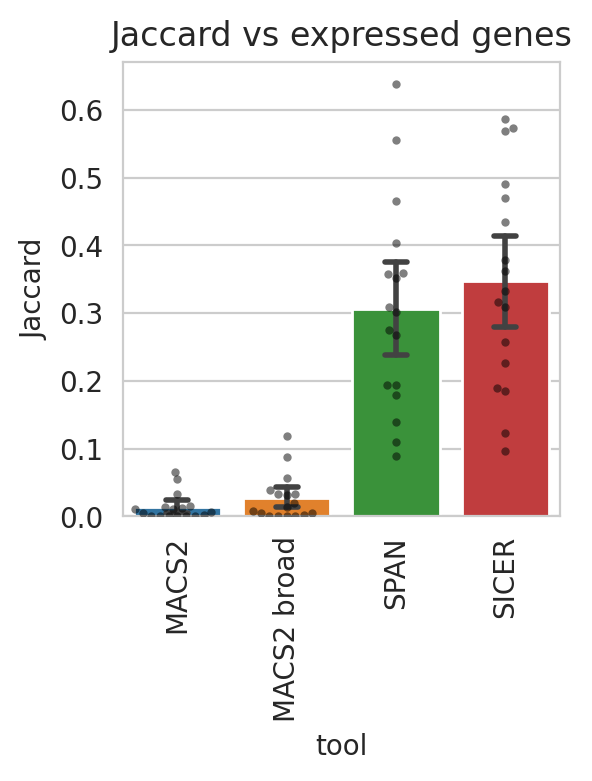

In [84]:
print('ENCODE')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
sns.barplot(data=encode_genes_df, x='tool', y='jaccard',
            capsize=.2, errwidth=2,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax,)
sns.swarmplot(data=encode_genes_df, x='tool', y='jaccard',
              dodge=True, size=3, color="black", alpha=0.5,
              order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [85]:
immune_genes_df = genes_overlap(df_immune_peaks, immune_expression)
immune_genes_df.sample(3)

  0%|          | 0/32 [00:00<?, ?it/s]

,cell,replicate,tool,peaks,peaks_len,genes,genes_len,peaks_overlap,genes_overlap,overlap_len,precision,sensitivity,f1,jaccard
0,Monocyte,,MACS2,127115,0.0,18584,971224167,123404,11629,174884844,0.970806,0.625753,0.760993,0.219611
4,BCell,,MACS2 broad,152502,0.0,20769,1118480271,147125,13152,227567340,0.964741,0.633251,0.764614,0.255432
9,Monocyte,,SPAN,20074,0.0,18584,971224167,19679,12141,276619243,0.980323,0.653304,0.784082,0.398240


Roadmap


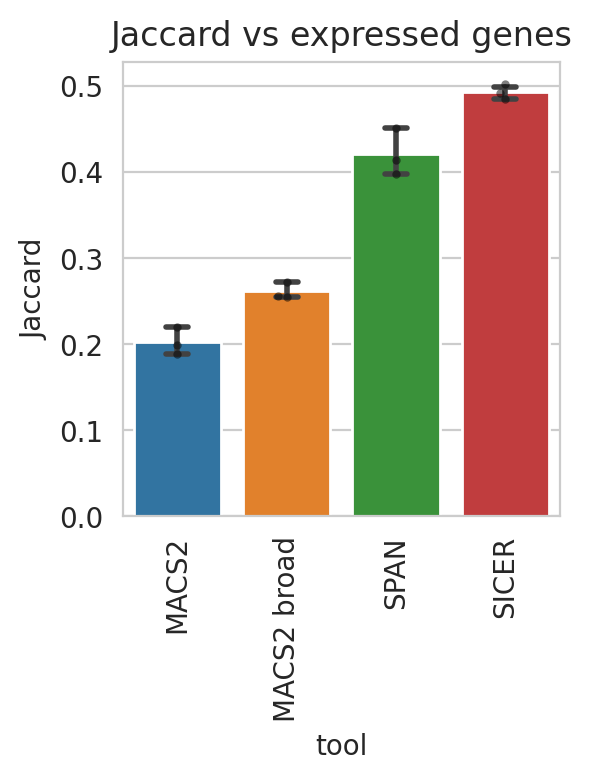

In [86]:
print('Roadmap')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
sns.barplot(data=immune_genes_df, x='tool', y='jaccard',
            capsize=.2, errwidth=2,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=immune_genes_df, x='tool', y='jaccard',
              dodge=True, size=3, color="black", alpha=0.5,
              order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

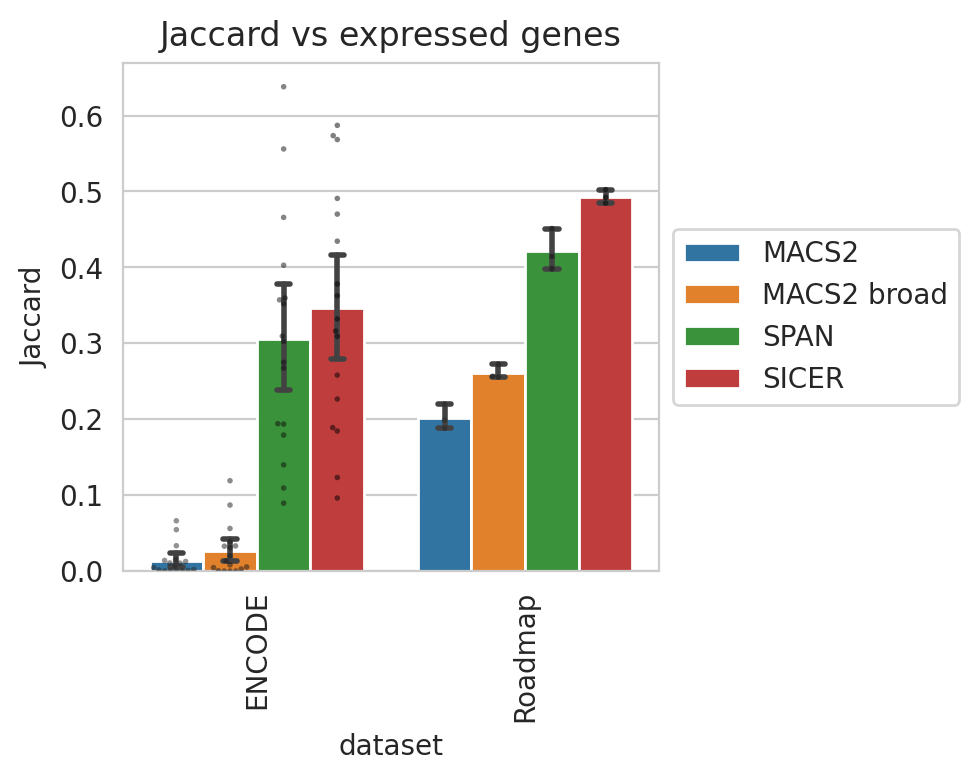

In [87]:
encode_genes_df['dataset'] = 'ENCODE'
immune_genes_df['dataset'] = 'Roadmap'
t = pd.concat([encode_genes_df, immune_genes_df]).reset_index(drop=True)
plt.figure(figsize=(5, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
sns.barplot(data=t, x='dataset', y='jaccard', hue='tool',
            capsize=.05, errwidth=2,
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='jaccard', hue='tool',
              dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Compare ratio of peaks to genes

In [90]:
import tempfile

def genes_peaks_ratio(df_peaks, expression):
    tf = tempfile.mktemp()

    rows = []
    for _, (c, r, tool, file) in tqdm(list(df_peaks[df_peaks['modification'] == 'H3K36me3']
                                      [['cell', 'replicate', 'tool', 'file']].iterrows())):
        # print(c, r, tool, file)
        if (c, r) not in expression:
            continue
        genes_file = sorted_file(expression[c, r])
        peaks_file = sorted_file(file)
        ! echo "" > {tf}
        ! bedtools intersect -a {genes_file} -b {peaks_file} -wa -wb > {tf}
        expr_cols = len(pd.read_csv(genes_file, sep='\t', header=None, nrows=1).columns)
        try:
            tf_expression = pd.read_csv(tf, sep='\t', header=None)
            genes = len(tf_expression.groupby([0, 1, 2]).count())
            peaks = len(tf_expression.groupby([expr_cols, expr_cols + 1, expr_cols + 2]).count())
            rows.append((c, r, tool, genes, peaks))
        except:
            pass

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'tool', 'genes', 'peaks'],
        dtype=object
    )
    df['peaks_to_genes'] = df['peaks'] / df['genes']
    return df

In [91]:
encode_genes_ratios = genes_peaks_ratio(df_encode_peaks, encode_expression)
encode_genes_ratios.sample(3)

  0%|          | 0/68 [00:00<?, ?it/s]

,cell,replicate,tool,genes,peaks,peaks_to_genes
54,NHLF,rep1,SPAN,11260,36320,3.225577
30,NHLF,rep1,SICER,11501,41607,3.617685
60,GM12878,rep2,SPAN,11496,21445,1.865431


ENCODE


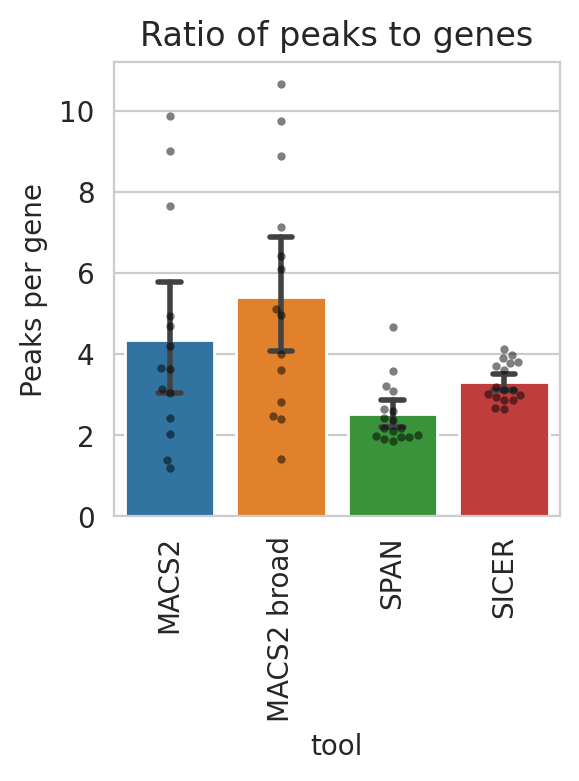

In [99]:
print('ENCODE')
plt.figure(figsize=(3, 4))
ax = plt.axes()
sns.barplot(data=encode_genes_ratios, y='peaks_to_genes', x='tool', 
            capsize=.2, errwidth=2,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=encode_genes_ratios, y='peaks_to_genes', x='tool',
              dodge=True, size=3, color="black", alpha=0.5,
              order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_ylabel('Peaks per gene')
ax.title.set_text('Ratio of peaks to genes')
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

In [93]:
immune_genes_ratios = genes_peaks_ratio(df_immune_peaks, immune_expression)
immune_genes_ratios.sample(3)

  0%|          | 0/32 [00:00<?, ?it/s]

,cell,replicate,tool,genes,peaks,peaks_to_genes
3,Monocyte,,MACS2 broad,12041,102429,8.506685
1,TCell,,MACS2,12673,178040,14.048765
4,BCell,,MACS2 broad,13151,147125,11.187362


Immune


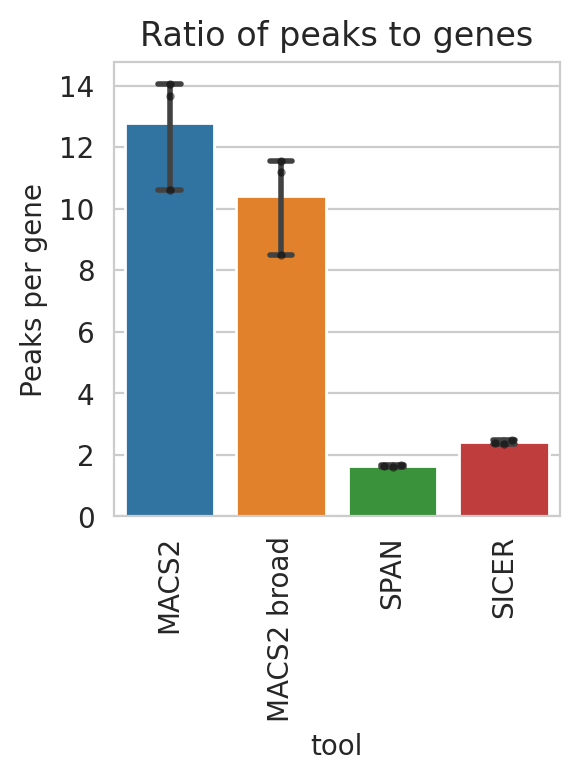

In [94]:
print('Immune')
plt.figure(figsize=(3, 4))
ax = plt.axes()
sns.barplot(data=immune_genes_ratios, y='peaks_to_genes', x='tool',
            capsize=.2, errwidth=2,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=immune_genes_ratios, y='peaks_to_genes', x='tool',
              dodge=True, size=3, color="black", alpha=0.5,
              order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_ylabel('Peaks per gene')
ax.title.set_text('Ratio of peaks to genes')
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

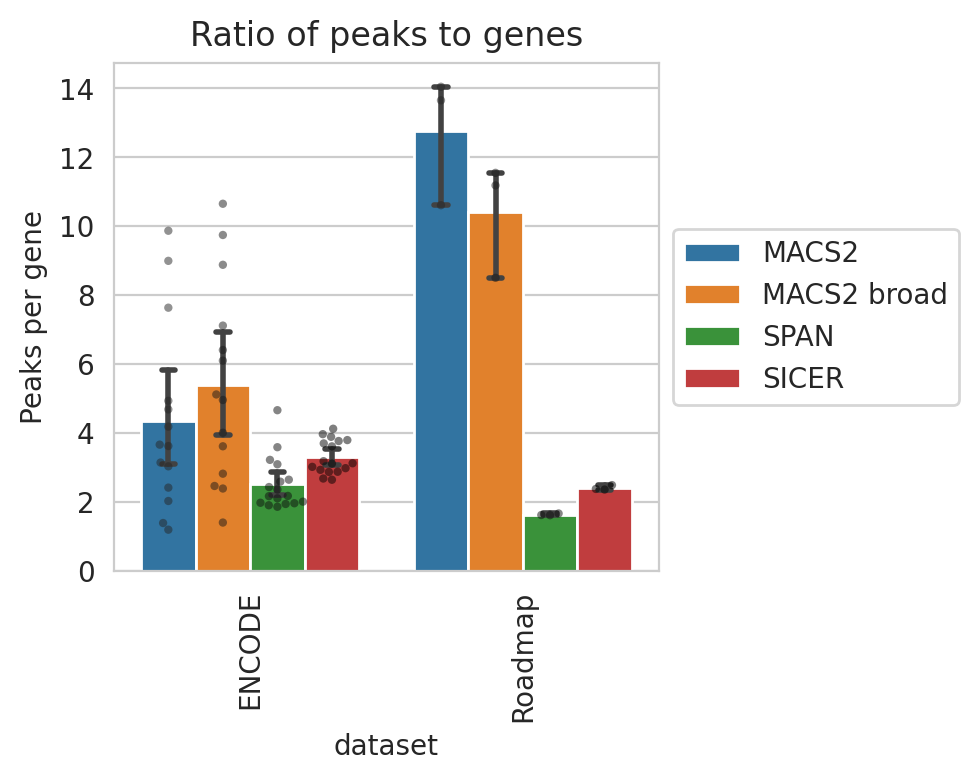

In [95]:
encode_genes_ratios['dataset'] = 'ENCODE'
immune_genes_ratios['dataset'] = 'Roadmap'
t = pd.concat([encode_genes_ratios, immune_genes_ratios]).reset_index(drop=True)
plt.figure(figsize=(5, 4))
ax = plt.axes()
sns.barplot(data=t, y='peaks_to_genes', x='dataset', hue='tool',
            capsize=.05, errwidth=2,
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=t, y='peaks_to_genes', x='dataset', hue='tool',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_ylabel('Peaks per gene')
ax.title.set_text('Ratio of peaks to genes')
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# H3K36me3 overlap vs genes benchmark

In [97]:
import pyranges as pr
from pyranges import PyRanges


def genes_overlap(df_peaks, expression_genes):

    rows = []
    for _, (c, r, tool, file) in tqdm(list(df_peaks[df_peaks['modification'] == 'H3K36me3']
                                           [['cell', 'replicate', 'tool', 'file']].iterrows())):
        # print(c, r, tool, file)
        if (c, r) not in expression_genes:
            continue
        genes_file = pr.read_bed(sorted_file(expression_genes[c, r]))
        genes = len(genes_file)
        if lines(file) == 0:
            for top in np.linspace(1000, 15000, 15):
                rows.append((c, r, top, genes, file, 0, 0, 0, tool))
            continue
        peaks_file = pr.read_bed(sorted_file(file), as_df=True)
        peaks_file.sort_values(
            by=peaks_file.columns[8] if len(peaks_file.columns) >= 9 else peaks_file.columns[4],
            ascending=False, inplace=True
        )
        for top in np.linspace(1000, 15000, 15):
            t = PyRanges(peaks_file.head(int(top)).sort_values(by=['Chromosome', 'Start']))
            peaks = len(t)
            peaks_overlap = len(t.overlap(genes_file))
            tss_overlap = len(genes_file.overlap(t))
            rows.append((c, r, top, genes, file, peaks, peaks_overlap, tss_overlap, tool))

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
        dtype=object
    )
    df['p'] = (df['pg'] + df['gp']) / 2
    df['precision'] = [d(x, y) for x, y in zip(df['pg'], df['peaks'])]
    df['sensitivity'] = [d(x, y) for x, y in zip(df['gp'], df['genes'])]
    df['f1'] = [
        2 / (d(1, s + 1e-10) + d(1, p + 1e-10))
        for s, p in zip(df['sensitivity'], df['precision'])]
    return df

In [98]:
encode_genes_ovlp_df = genes_overlap(df_encode_peaks, encode_expression)
encode_genes_ovlp_df.sample(3)

  0%|          | 0/68 [00:00<?, ?it/s]

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
116,HepG2,rep2,12000.0,17175,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,3561,3539,1462,MACS2,2500.5,0.993822,0.085124,0.156816
631,Huvec,rep2,2000.0,19526,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,2000,1993,2363,SICER,2178.0,0.996500,0.121018,0.215826
970,Huvec,rep2,11000.0,19526,/home/jetbrains/data/2023_GSE26320/span/GSM646...,11000,10926,7978,SPAN,9452.0,0.993273,0.408583,0.578996


ENCODE


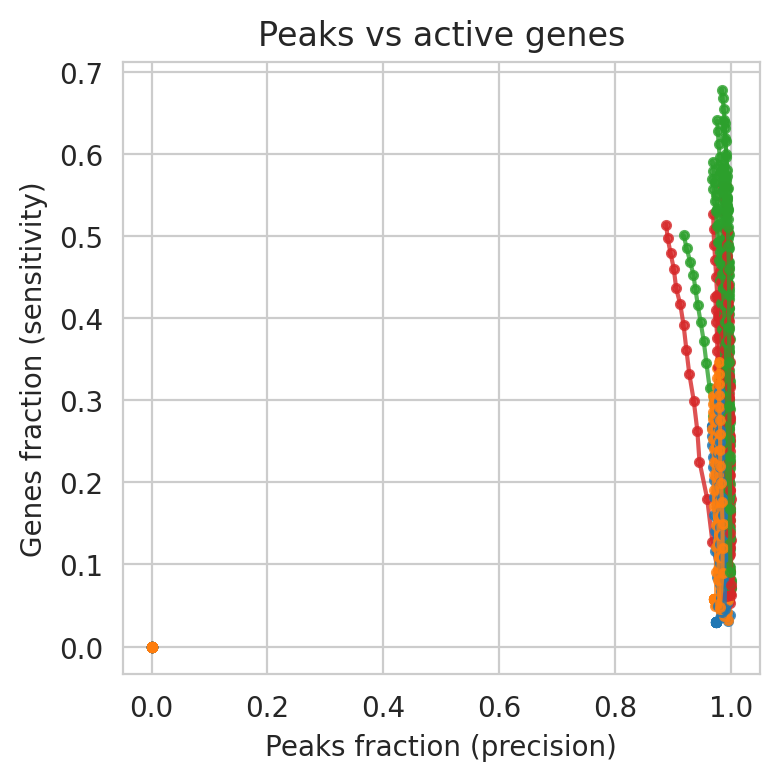

In [100]:
print('ENCODE')
plt.figure(figsize=(4, 4))
for (c, r, t), dft in encode_genes_ovlp_df.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.8)
plt.title('Peaks vs active genes')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Genes fraction (sensitivity)')
plt.tight_layout()
plt.show()

In [101]:
encode_genes_ovlp_df[(encode_genes_ovlp_df['sensitivity'] > 0.7) & 
                     (encode_genes_ovlp_df['precision'] < 0.99)]

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1


ENCODE


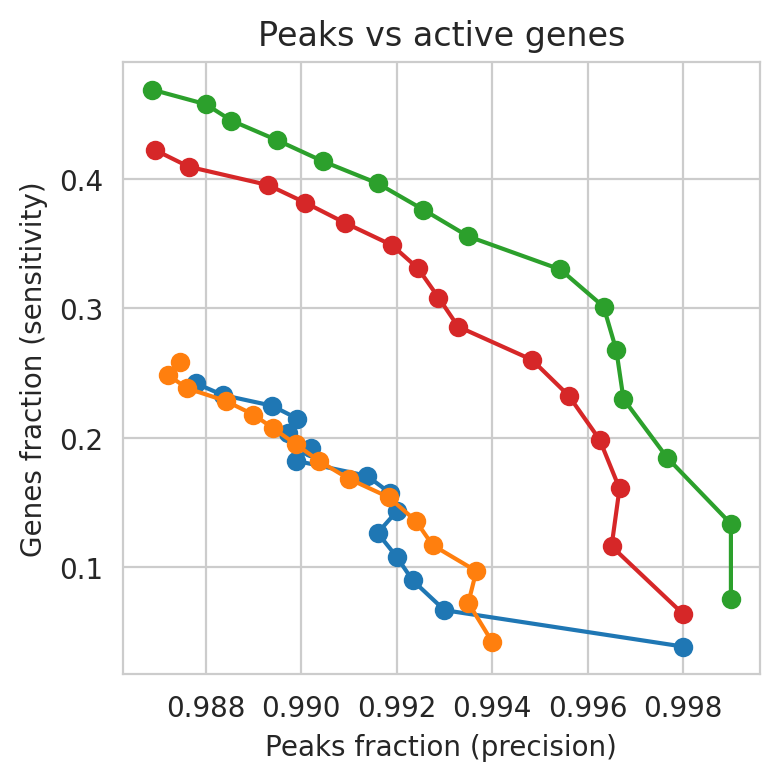

In [102]:
print('ENCODE')
plt.figure(figsize=(4, 4))
cr = encode_genes_ovlp_df[(encode_genes_ovlp_df['cell'] == 'H1') &
                          (encode_genes_ovlp_df['replicate'] == 'rep1')]
for (c, r, t), dft in cr.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', color=TOOLS_PALETTE[t], alpha=1.0)
plt.title('Peaks vs active genes')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Genes fraction (sensitivity)')
plt.tight_layout()
plt.show()

In [103]:
rows = []
for (c, r, t), dft in encode_genes_ovlp_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = 0, 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
encode_genes_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
encode_genes_aps_df.sample(3)

,cell,replicate,tool,auc
23,HMEC,rep2,SPAN,0.516474
32,HepG2,rep1,MACS2,0.257817
64,NHLF,rep2,MACS2,0.284288


ENCODE


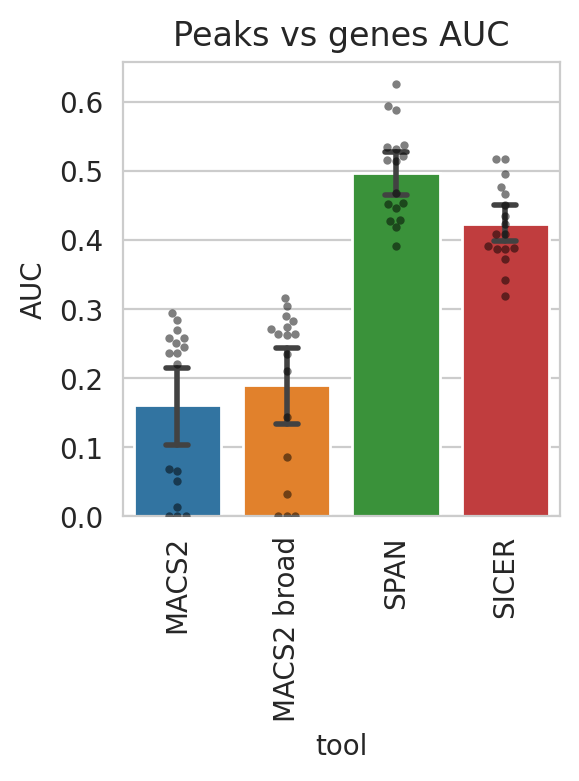

In [104]:
print('ENCODE')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs genes AUC')
g_results = sns.barplot(data=encode_genes_aps_df, x='tool', y='auc',
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
sns.swarmplot(data=encode_genes_aps_df, x='tool', y='auc',
              dodge=True, size=3, color="black", alpha=0.5,
              order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)

ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

In [105]:
immune_genes_ovlp_df = genes_overlap(df_immune_peaks, immune_expression)
immune_genes_ovlp_df.sample(3)

  0%|          | 0/32 [00:00<?, ?it/s]

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
38,BCell,,9000.0,20769,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,9000,8964,4871,MACS2,6917.5,0.9960,0.234532,0.379664
151,TCell,,2000.0,21110,/home/jetbrains/data/2023_Immune/span/TCell_H3...,2000,1999,3497,SPAN,2748.0,0.9995,0.165656,0.284208
5,Monocyte,,6000.0,18584,/home/jetbrains/data/2023_Immune/macs2/Monocyt...,6000,5982,4113,MACS2,5047.5,0.9970,0.221319,0.362229


Immune


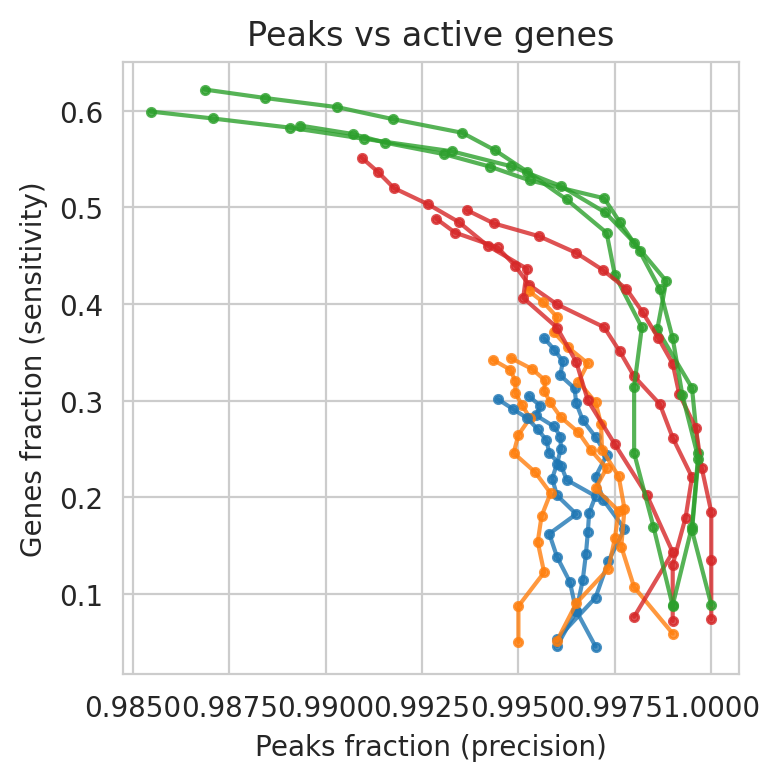

In [106]:
print('Immune')
plt.figure(figsize=(4, 4))
for (c, r, t), dft in immune_genes_ovlp_df.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.8)
plt.title('Peaks vs active genes')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Genes fraction (sensitivity)')
plt.tight_layout()
plt.show()

Immune


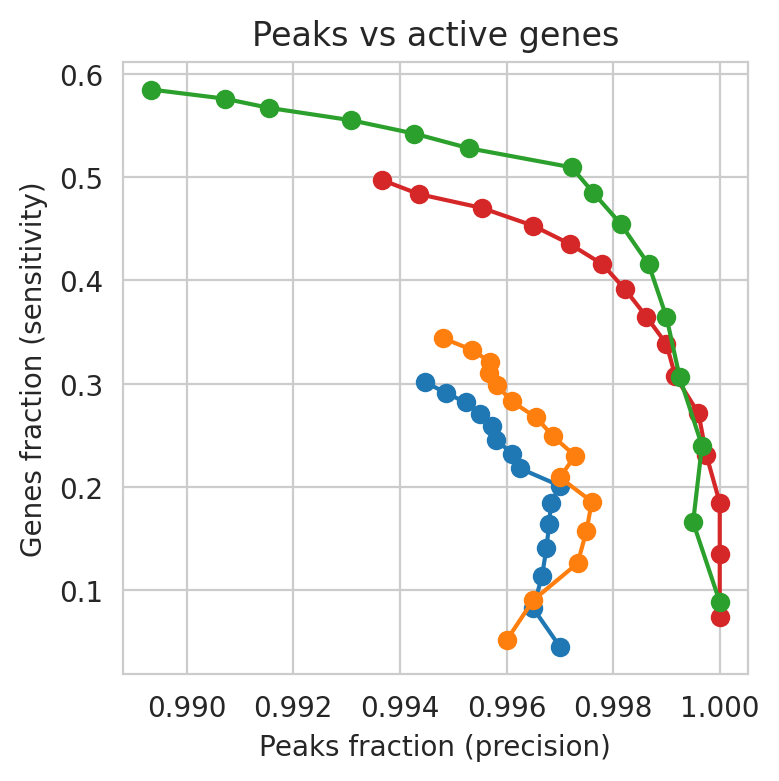

In [107]:
print('Immune')
plt.figure(figsize=(4, 4))
cr = immune_genes_ovlp_df[immune_genes_ovlp_df['cell'] == 'TCell']
for (c, r, t), dft in cr.groupby(['cell', 'replicate', 'tool']):
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', color=TOOLS_PALETTE[t], alpha=1.0)
plt.title('Peaks vs active genes')
plt.xlabel('Peaks fraction (precision)')
plt.ylabel('Genes fraction (sensitivity)')
plt.tight_layout()
plt.show()

In [108]:
rows = []
for (c, r, t), dft in immune_genes_ovlp_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = 0, 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
immune_genes_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
immune_genes_aps_df.sample(3)

,cell,replicate,tool,auc
6,Monocyte,,SICER,0.511735
4,Monocyte,,MACS2,0.337058
1,BCell,,MACS2 broad,0.315885


Immune


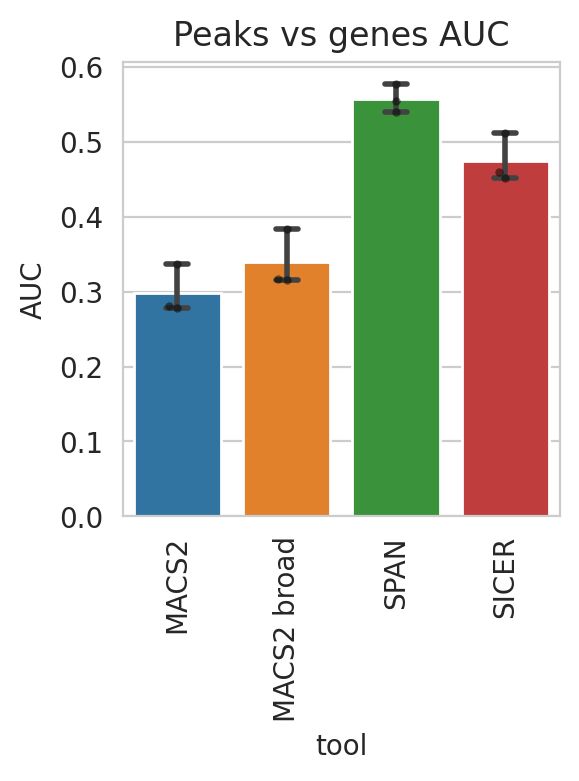

In [109]:
print('Immune')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs genes AUC')
g_results = sns.barplot(data=immune_genes_aps_df, x='tool', y='auc',
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
sns.swarmplot(data=immune_genes_aps_df, x='tool', y='auc',
              dodge=True, size=3, color="black", alpha=0.5,
              order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

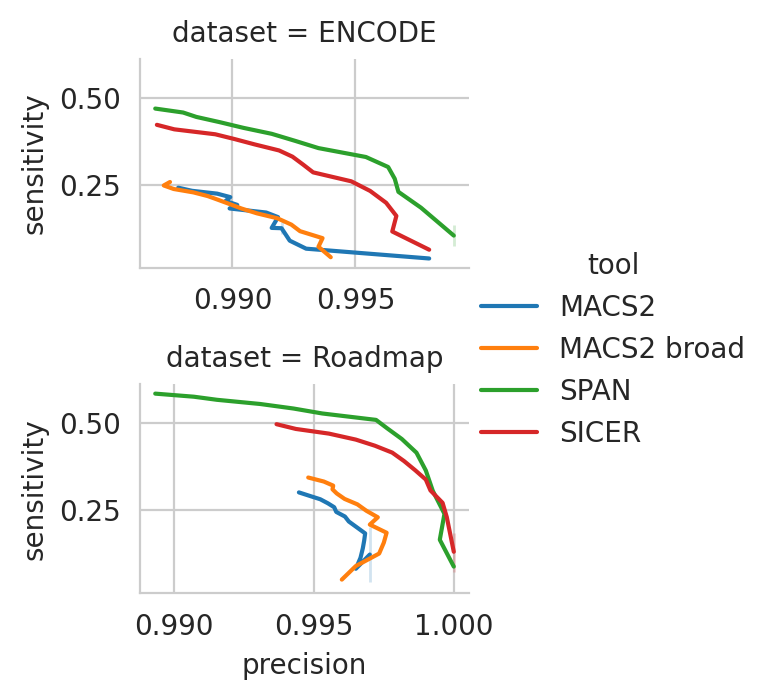

In [110]:
t1 = encode_genes_ovlp_df[(encode_genes_ovlp_df['cell'] == 'H1') &
                          (encode_genes_ovlp_df['replicate'] == 'rep1')].copy()
t1['dataset'] = 'ENCODE'
t2 = immune_genes_ovlp_df[immune_genes_ovlp_df['cell'] == 'TCell'].copy()
t2['dataset'] = 'Roadmap'
covlp_df = pd.concat([t1, t2]).reset_index(drop=True)
g = sns.FacetGrid(covlp_df, hue="tool", row="dataset", height=1.8, aspect=1.5, sharex=False,
                  palette=TOOLS_PALETTE, hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
g.map(sns.lineplot, "precision", "sensitivity", markers=True, sort=False)
g.add_legend()
plt.show()


Roadmap + ENCODE


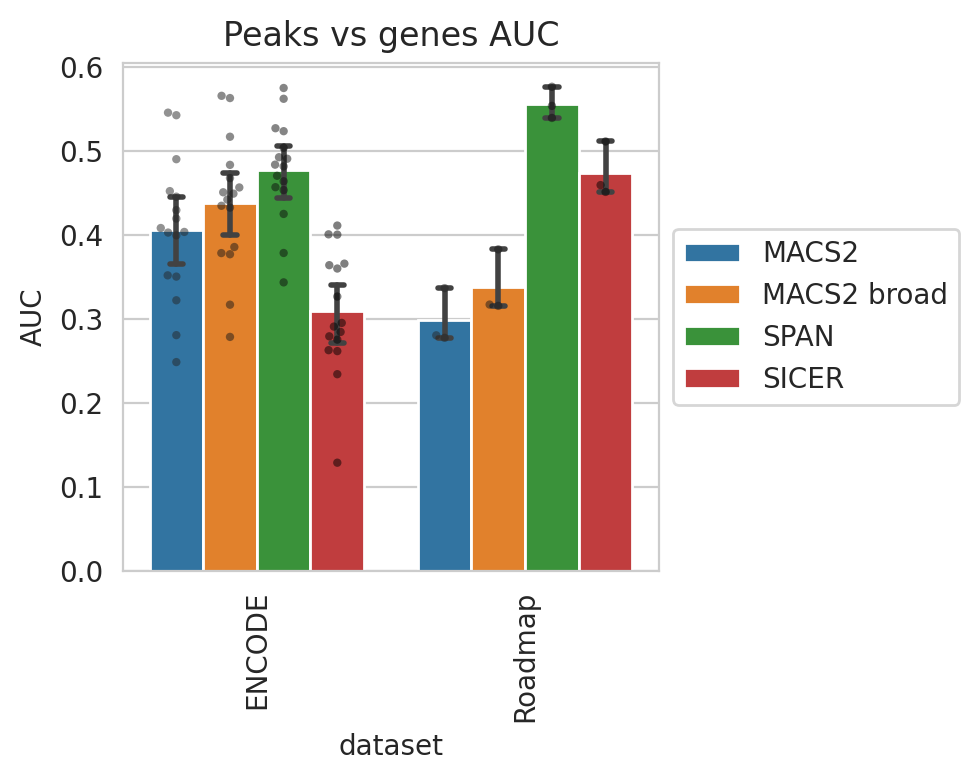

In [111]:
print('Roadmap + ENCODE')
encode_genes_aps_df['dataset'] = 'ENCODE'
immune_genes_aps_df['dataset'] = 'Roadmap'
t = pd.concat([encode_aps_df, immune_genes_aps_df]).reset_index(drop=True)
plt.figure(figsize=(5, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs genes AUC')
sns.barplot(data=t, x='dataset', y='auc', hue='tool',
            capsize=.05, errwidth=2,
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='auc', hue='tool',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()